In [4]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import pandas as pd


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

plt.rcParams.update({'font.size': 22})


DEVICE = 'cuda'

In [5]:
RUN = '_m9_nsub5_nsim100'
nsubstring = '-5M9'


SYSTEM_NAME = "ngc4414"

NSIM = 10000
NSIM = 100
SIM_PATH = f'/nfs/scratch/eliasd/store{RUN}.zarr' 

# UNet =  f'UNet{RUN}.pt'


SIGMA = 0.1

In [ ]:
lr         = float(sys.argv[1])
max_epochs = int(sys.argv[2])

### Utilities

In [6]:
def get_config(system_name: str, nsub: str = '') -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config(f'config-sub{nsub}.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    
    nsub = main.sub.nsub
    lows = np.tile(lows, nsub)
    highs = np.tile(highs, nsub)
    
    uv = lambda u: (highs - lows) * u + lows
    
    return swyft.Prior(uv, nsub*2), uv
#     return swyft.Prior(uv, 2), uv


def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    nsub = config.umodel.alphas["main"].sub.nsub
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    if not torch.is_tensor(v):
        v = torch.tensor(v)

    xy_sub = v.view(-1,2).to(DEVICE)
    d_p_sub = dist.Delta(xy_sub).to_event(1)
    
#     x_sub, y_sub = np.squeeze(v.T)
#     d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)


    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}


In [ ]:
[[1, 2],
 [3, 4],
 [6, 7]]

### Check utilities

In [7]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME, nsubstring)
torch.set_default_tensor_type(torch.FloatTensor)

In [8]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

tensor([[-2.4635, -0.0381],
        [-2.2768,  0.3557],
        [-0.3846, -0.9160],
        [ 0.3412, -0.8713],
        [-1.8368,  0.9490]], device='cuda:0')
{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')}


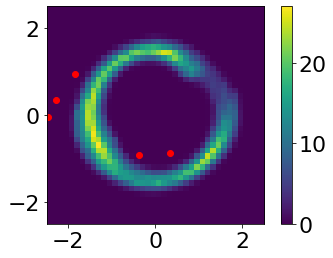

In [9]:
# v = ppd['main/sub/p_sub']['value']
# sim = simul(v, CONFIG)

# print(v)
# print(sim)

# plt.scatter(*v.t(), c="r")
# plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
# plt.colorbar()
# plt.show()

### Simulate

In [11]:
prior, uv = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]
nsub = CONFIG.umodel.alphas["main"].sub.nsub
print(f'nsub = {nsub}')

nsub = 5


In [12]:
pnames = [f'{z}_{i+1}' for i in range(nsub) for z in ['x', 'y']]
print(pnames)
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
#                             pnames = ["x_sub", "y_sub"],
                            pnames = pnames,
                            sim_shapes={"image": (nx, ny)})

store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)
# store = swyft.MemoryStore(simulator=simulator)

store.add(NSIM, prior)
store.simulate()

['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'x_4', 'y_4', 'x_5', 'y_5']
Creating new store.
Store: Adding 10006 new samples to simulator store.


### Check store

In [14]:
N = 50
coords_x = np.array([store[i][1][0::2] for i in range(N)])
coords_y = np.array([store[i][1][1::2] for i in range(N)])
imgs = np.array([store[i][0]['image'] for i in range(N)])

### Train

In [17]:
idx = 0
img_0 = store[idx][0]['image']
L1, L2 = tensor(img_0.shape)
assert L1 == L2
L = L1.item()
print(f'L = {L}')

L = 40


In [18]:
torch.set_default_tensor_type(torch.FloatTensor)
dataset = swyft.Dataset(NSIM, prior, store)#, simhook = noise)
marginals = [i for i in range(L**2)]
# post = swyft.Posteriors(dataset)

In [19]:
def coord_uv(coords_u, lows, highs):
#     highs_l = np.repeat(highs, coords_u)
#     lows_l = np.repeat(lows, coords_u)
    highs_l = np.full_like(coords_u, highs)
    lows_l = np.full_like(coords_u, lows)
    
    v = lambda u: (highs_l - lows_l) * u + lows_l
    coords_v = v(coords_u)
    return coords_v

def coord_to_map(XY_u):
    
    y0, y1, x0, x1 = -2.5, 2.5, -2.5, 2.5
    lows, highs = -2.5, 2.5
    res = 0.125
    
    XY = XY_u
    
    n_batch =  XY.shape[0]
    n_coords = XY.shape[1]
        
    binary_map = torch.zeros((n_batch, L,L), device = DEVICE)
    
    x, y = XY[:,0::2], XY[:,1::2]
    
    x_i = torch.floor((x*L).flatten()).type(torch.long) 
    y_i = torch.floor((y*L).flatten()).type(torch.long) 

    if n_coords != 0:
        i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long) 
    
        xx = tuple(torch.stack((i, y_i, x_i)))
        binary_map[xx] = 1

    return binary_map
    

class DoubleConv(swyft.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(swyft.Module):
    def __init__(self, n_features, marginals):
        super().__init__(n_features, marginals) 
#         super(UNET, self).__init__()
        
        self.marginals = marginals
        self.n_features = n_features
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        
        in_channels=1
        out_channels=2
        features=[64, 128, 256, 512]

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, sims, target):
                
        sims = sims.view(-1, L, L)
        z = coord_to_map(target)
    
        ############# UNet Start ###
        x = sims
        n_batch = len(x)
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        ############# UNet End ###

        
                
        # L[C]
        x_new = x[:,0] * (1 - z) + x[:,1] * z
        
        
        x = x_new
        x = x.view(-1, self.n_features)
        return x

class CustomHead(swyft.Module):

    def __init__(self, obs_shapes) -> None:
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = torch.prod(tensor(obs_shapes['image']))

    def forward(self, obs) -> torch.Tensor:
        x = obs["image"]
        n_batch = len(x)
        x = x.view(n_batch, self.n_features)
        return x

In [20]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
        
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.legend()
    plt.show()

In [58]:
factor = np.power(10, -1.75)
patience = 4

save_id = f'lr{np.log10(lr)}_fac{np.log10(factor)}_pat{patience}'
save_name = f'UNet_{save_id}.pt'
save_path = os.path.join('posts_m9', save_name)

In [ ]:
print(f'Training {save_name}!')
    
torch.set_default_tensor_type(torch.FloatTensor)
post = swyft.Posteriors(dataset)
post.add(marginals, device = DEVICE, head = CustomHead, tail = UNET)
post.train(marginals, max_epochs = max_epochs,
           optimizer_args = dict(lr=lr),
           scheduler_args = dict(factor = factor, patience = patience)
          )

post.save(save_path)
print('Done!')